In [27]:
import hiive.mdptoolbox.example
import hiive.mdptoolbox.mdp as mdp
import gym
import numpy as np
import matplotlib.pylab as plt
from gym.envs.toy_text.frozen_lake import generate_random_map
import seaborn as sns
from time import time
plt.style.use("ggplot")

In [28]:
# Helper functions
np.random.seed(0)
def get_transitions_rewards(env, num_states, num_actions):
    reward_matrix = np.zeros((num_states, num_actions))
    transition_matrix = np.zeros((num_actions, num_states, num_states))

    for s in range(num_states):
        for a in range(num_actions):
            for proba_matrix in env.P[s][a]:
                transition_prob, new_state, reward, done = proba_matrix
                reward_matrix[s, a] = reward
                transition_matrix[a, s, new_state] += transition_prob
            transition_matrix[a, s, :] = transition_matrix[a, s,:] / np.sum(transition_matrix[a, s,:])
  
    return transition_matrix, reward_matrix
def plot_result(stats,method='PI',name='Error'):
    fun = lambda x: x[name]
    vecFun=np.vectorize(fun)
    curve = vecFun(stats)
    plt.plot(curve,label =method)
    plt.title(name)
    plt.xlabel('Iteration')
    plt.ylabel(name)

    plt.legend()


def bar_plot(ax, data, colors=None, total_width=0.8, single_width=1, legend=True):
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    n_bars = len(data)

    bar_width = total_width / n_bars

    bars = []

    for i, (name, values) in enumerate(data.items()):
  
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])

        bars.append(bar[0])

    # Draw legend if we need
    if legend:
        ax.legend(bars, data.keys())

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
def success(env,solver):
    print(solver.policy)
    goal=0
    total_steps=0
    success_steps=0
    for i in range(100):
        np.random.seed(i)
        env.seed(i)
        steps=0
        env.reset() 
        new_state=0
        done = False
        new_state = 0
        while not done:
            steps+=1
            new_state, reward, done, info = env.step(solver.policy[new_state])
            # env.render()
            if done:
                total_steps+=steps
                if reward==1:#new_state==env.observation_space.n-1:
                    success_steps+=steps     
                    goal +=1 
                
    print(f"success=%{goal}")
    if goal!=0:
        print(f"Avg success Steps= {success_steps/goal}")
    print(f"Total steps={total_steps/100}")
    
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

# Environment : Frozen Lake

In [45]:
# large_map = generate_random_map(size=8, p=0.8)
# # actions = {
#     'Left': 0,
#     'Down': 1,
#     'Right': 2, 
#     'Up': 3
# }

env = gym.make("FrozenLake-v0",is_slippery=True)

###################################
np.random.seed(0)
env.seed(0)
###################################

env.reset()                    
n_state = env.observation_space.n
n_actions = env.action_space.n
print(n_state)

16


# Policy Iteration and Value Iteratrion

Converged after 227 value iterations
[0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]
Won 80 of 100 games!
[[0.54201404 0.49878743 0.47067727 0.45683193]
 [0.5584404  0.         0.35834012 0.        ]
 [0.59179013 0.64307363 0.61520214 0.        ]
 [0.         0.74171617 0.86283528 0.        ]]


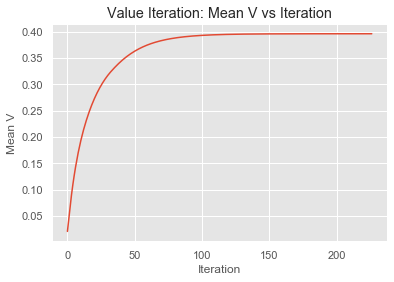

In [49]:
### Value ITERATION######

def eval_state_action(env,V, s, a, gamma=0.99):
    return np.sum([p * (rew + gamma*V[next_s]) for p, next_s, rew, _ in env.P[s][a]])

def value_iteration(env,nS,nA,eps=0.0001,g=0.99):
    '''
    Value iteration algorithm
    '''
    # # spaces dimension
    nA = env.action_space.n
    nS = env.observation_space.n
    V = np.zeros(nS)
    it = 0
    avg_V=[]
    while True:
        delta = 0
        # update the value of each state using as "policy" the max operator
        for s in range(nS):
            old_v = V[s]
            V[s] = np.max([eval_state_action(env,V, s, a,g) for a in range(nA)])
            delta = max(delta, np.abs(old_v - V[s]))
            # deltas.append(delta)
        if delta < eps:
            break
        # else:
        #     print('Iter:', it, ' delta:', np.round(delta, 5))

        avg_V.append(np.mean(V))
        it += 1

    return V,avg_V,it

def run_episodes(env, V, num_games=100):
    '''
    Run some test games
    '''
    tot_rew = 0
    state = env.reset()

    for _ in range(num_games):
        done = False
        while not done:
            action = np.argmax([eval_state_action(env,V, state, a) for a in range(nA)])
            next_state, reward, done, _ = env.step(action)

            state = next_state
            tot_rew += reward 
            if done:
                state = env.reset()
    print('Won %i of %i games!'%(tot_rew, num_games))
    return tot_rew

def policy_maker(env,V,n_states,n_actions,g):
    policy=[]
    for s in range(n_states):
        policy.append(np.argmax([eval_state_action(env,V, s, a,g) for a in range(n_actions)]))
    return policy

def value_iteration_fun(env,nS,nA,eps=0.00001,gamma=0.99):
    # Value iteration
    start_time=time()
    V,vi_error,vi_conv_iter = value_iteration(env,nS,nA,eps,gamma)

    vi_conv_time = time()-start_time
    return V,vi_error,vi_conv_iter,vi_conv_time

nA = env.action_space.n
nS = env.observation_space.n
V,vi_mean,vi_conv_iter,vi_conv_time = value_iteration_fun(env,nS,nA,eps=0.00001,gamma=0.99)
print('Converged after %i value iterations'%(vi_conv_iter))

vi_V = V.reshape((4,4))

plt.plot(vi_mean)
plt.title("Value Iteration: Mean V vs Iteration")
plt.ylabel("Mean V")
plt.xlabel("Iteration")

vi_policy = policy_maker(env,V,nS,nA,g=0.99)#.reshape((4,4)
print(vi_policy)
# print(policy.reshape((4,4)))
# test the value function on 100 games
vi_tot_rew = run_episodes(env, V, 100)
# print the state values
print(vi_V.reshape((4,4)))

Converged after 7 policy iterations
Won 81 of 100 games!
[[0.54190413 0.49864168 0.47050682 0.45664901]
 [0.55834276 0.         0.35826653 0.        ]
 [0.59171052 0.64301636 0.61515206 0.        ]
 [0.         0.74167671 0.86281536 0.        ]]
[[0. 3. 3. 3.]
 [0. 0. 0. 0.]
 [3. 1. 0. 0.]
 [0. 2. 1. 0.]]


Text(0.5, 0, 'Iteration')

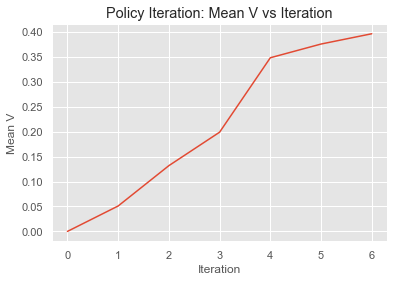

In [57]:
### POLICY ITERATION######
def eval_state_action(env,V, s, a, gamma=0.99):
    return np.sum([p * (rew + gamma*V[next_s]) for p, next_s, rew, _ in env.P[s][a]])

def policy_evaluation(env,V, policy,gamma=0.99, eps=0.00001):
    '''
    Policy evaluation. Update the value function until it reach a steady state
    '''
    # deltas=[]
    while True:
        delta = 0
        for s in range(nS):
            old_v = V[s]
            # update V[s] using the Bellman equation
            V[s] = eval_state_action(env,V, s, policy[s],gamma)
            delta = max(delta, np.abs(old_v - V[s]))
            # deltas.append(delta)
        if delta < eps:
            break
    return V

def policy_improvement(env,V, policy,nS,nA):
    '''
    Policy improvement. Update the policy based on the value function
    '''
    nS = env.observation_space.n
    nA = env.action_space.n
    policy_stable = True
    for s in range(nS):
        old_a = policy[s]
        # update the policy with the action that bring to the highest state value
        policy[s] = np.argmax([eval_state_action(env,V, s, a) for a in range(nA)])
        if old_a != policy[s]: 
            policy_stable = False

    return policy_stable, policy,np.mean(V)


def run_episodes(env, policy, num_games=100):
    '''
    Run some games to test a policy
    '''
    tot_rew = 0
    state = env.reset()

    for _ in range(num_games):
        done = False
        while not done:
            # select the action accordingly to the policy
            next_state, reward, done, _ = env.step(policy[state])
                
            state = next_state
            tot_rew += reward 
            if done:
                state = env.reset()

    print('Won %i of %i games!'%(tot_rew, num_games))
    return tot_rew
#######################################################
def policy_iteration(env,gamma,nS,nA):
    pi_V = np.zeros(nS)
    pi_policy = np.zeros(nS)
    
    policy_stable = False
    it = 0
    PI_avg_V=[]
    pi_conv_time=0
    start_time=time()
    while not policy_stable:
        pi_V = policy_evaluation(env,pi_V, pi_policy,gamma)
        policy_stable,pi_policy,avg_v = policy_improvement(env,pi_V, pi_policy,nS,nA)
        PI_avg_V.append(avg_v)
        it += 1
    pi_conv_time = time()-start_time
    pi_conv_iter = it
    return pi_V,pi_policy,pi_conv_iter,pi_conv_time,PI_avg_V

nA = env.action_space.n
nS = env.observation_space.n
pi_V,pi_policy,pi_conv_iter,pi_conv_time,PI_mean_V = policy_iteration(env,0.99,nS,nA)
print('Converged after %i policy iterations'%(pi_conv_iter))
pi_tot_rew=run_episodes(env, pi_policy)
pi_V = pi_V.reshape((4,4))
print(pi_V)
print(pi_policy.reshape((4,4)))
plt.plot(PI_mean_V)
plt.title("Policy Iteration: Mean V vs Iteration")
plt.ylabel("Mean V")
plt.xlabel("Iteration")
# pi_policy=pi_policy.reshape((4,4))

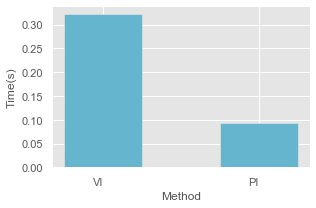

In [52]:

fig, ax = plt.subplots(figsize=(4.5,3))
ax.set_xticks(np.arange(2))
ax.bar(['VI','PI'],[vi_conv_time,pi_conv_time],width=0.5,align='center',color='c')
ax.set_xticklabels(['VI','PI'],rotation=0,ha='right')
plt.ylabel("Time(s)")
plt.xlabel("Method")

plt.tight_layout()

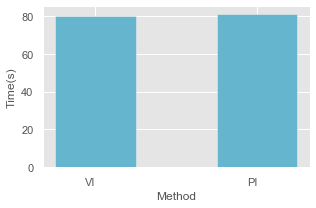

In [53]:
fig, ax = plt.subplots(figsize=(4.5,3))
ax.set_xticks(np.arange(2))
ax.bar(['VI','PI'],[vi_tot_rew,pi_tot_rew],width=0.5,align='center',color='c')
ax.set_xticklabels(['VI','PI'],rotation=0,ha='right')
plt.ylabel("Time(s)")
plt.xlabel("Method")

plt.tight_layout()

In [55]:
pi_policy

array([0., 3., 0., 3., 0., 0., 0., 0., 3., 1., 0., 0., 0., 2., 1., 0.])

In [56]:
np.array(vi_policy)

array([0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0], dtype=int64)

In [58]:
pi_policy == np.array(vi_policy)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [101]:
pi.policy

(0, 3, 3, 3, 0, 0, 2, 0, 3, 1, 0, 0, 0, 2, 1, 0)

In [102]:
vi.policy

(0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0)

In [24]:
# # actions = {
#     'Left': 0,
#     'Down': 1,
#     'Right': 2, 
#     'Up': 3
# }
pol=np.array(pi_policy).reshape(4,4)

labels = np.empty(pol.shape,dtype=object)
print(labels.shape)

for i in range(pol.shape[0]):
    for j in range(pol.shape[1]):
        if pol[i,j]==0:
            labels[i,j]='Left'
        elif pol[i,j]==1:
            labels[i,j]='Down'
        elif pol[i,j]==2:
            labels[i,j]='Right'
        else:
            labels[i,j]='Up'
    
labels

(4, 4)


array([['Left', 'Up', 'Left', 'Up'],
       ['Left', 'Left', 'Left', 'Left'],
       ['Up', 'Down', 'Left', 'Left'],
       ['Left', 'Right', 'Down', 'Left']], dtype=object)

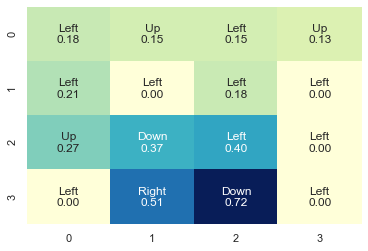

In [25]:
sns.set_theme()

tag = (np.asarray(["{0}\n{1:.2f}".format(label,vs) for label, vs in zip(labels.flatten(), pi_V.flatten())])).reshape(4,4)
fig, ax = plt.subplots()
ax = sns.heatmap(pi_V,annot=tag, cmap="YlGnBu", cbar=False,fmt = '')


VI policy sucess:
Won 47 of 100 games!
PI policy sucess:
Won 45 of 100 games!
VI policy sucess:
Won 44 of 100 games!
PI policy sucess:
Won 47 of 100 games!
VI policy sucess:
Won 78 of 100 games!
PI policy sucess:
Won 72 of 100 games!
VI policy sucess:
Won 76 of 100 games!
PI policy sucess:
Won 78 of 100 games!


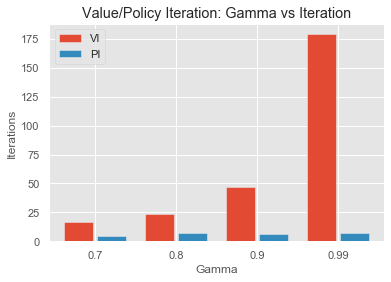

In [130]:
converge_iter = {"VI":[], "PI":[]}
converge_mean_v= {"VI":[], "PI":[]}
win_ratio= {"VI":[], "PI":[]}

range_gamma = [0.7,0.8,0.9,0.99]
nA = env.action_space.n
nS = env.observation_space.n
for gamma in range_gamma:
    V,vi_mean,vi_conv_iter,vi_conv_time = value_iteration_fun(env,eps=0.00001,gamma=gamma)
    viter_policy = policy_maker(V,nS,nA,g=gamma)
    converge_iter['VI'].append(vi_conv_iter)
    converge_mean_v['VI'].append(vi_mean[-1])

    print("VI policy sucess:")
    
    win_ratio['VI'].append(run_episodes(env, viter_policy))

    pi_V,p_iter_policy,pi_conv_iter,pi_conv_time,PI_avg_V = policy_iteration(env,gamma)
   
    converge_iter['PI'].append(pi_conv_iter)
    converge_mean_v['PI'].append(PI_avg_V[-1])


    print("PI policy sucess:")
    
    win_ratio['PI'].append(run_episodes(env, p_iter_policy))


fig, ax = plt.subplots()

ax.set_xticks(np.arange(len(converge_iter["VI"])))
ax.set_xticks(np.arange(len(range_gamma)))
ax.set_xticklabels(range_gamma)
bar_plot(ax, converge_iter, total_width=.8, single_width=.9)

plt.xlabel('Gamma')
plt.ylabel('Iterations')
plt.title("Value/Policy Iteration: Gamma vs Iteration")
# save_fig("LLE_heart_bic_vs_k")
plt.show()

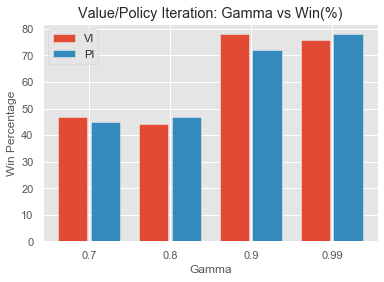

In [131]:
fig, ax = plt.subplots()

ax.set_xticks(np.arange(len(win_ratio["VI"])))
ax.set_xticks(np.arange(len(range_gamma)))
ax.set_xticklabels(range_gamma)
bar_plot(ax, win_ratio, total_width=.8, single_width=.9)

plt.xlabel('Gamma')
plt.ylabel('Win Percentage')
plt.title("Value/Policy Iteration: Gamma vs Win(%)")
# save_fig("LLE_heart_bic_vs_k")
plt.show()

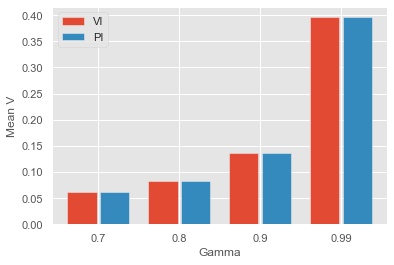

In [129]:
fig, ax = plt.subplots()

ax.set_xticks(np.arange(len(converge_mean_v["VI"])))
ax.set_xticks(np.arange(len(range_gamma)))
ax.set_xticklabels(range_gamma)
bar_plot(ax, converge_mean_v, total_width=.8, single_width=.9)

plt.xlabel('Gamma')
plt.ylabel('Mean V')
# save_fig("LLE_heart_bic_vs_k")
plt.show()

VI policy sucess:
(1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0)
success=%39
Avg success Steps= 30.384615384615383
Total steps=28.06
PI policy sucess:
(1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0)
success=%39
Avg success Steps= 30.384615384615383
Total steps=28.06
VI policy sucess:
(1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0)
success=%39
Avg success Steps= 30.384615384615383
Total steps=28.06
PI policy sucess:
(1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0)
success=%39
Avg success Steps= 30.384615384615383
Total steps=28.06
VI policy sucess:
(1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0)
success=%39
Avg success Steps= 30.384615384615383
Total steps=28.06
PI policy sucess:
(1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0)
success=%39
Avg success Steps= 30.384615384615383
Total steps=28.06
VI policy sucess:
(0, 3, 0, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0)
success=%74
Avg success Steps= 42.5
Total steps=47.56
PI policy sucess:
(0, 3, 0, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0)
su

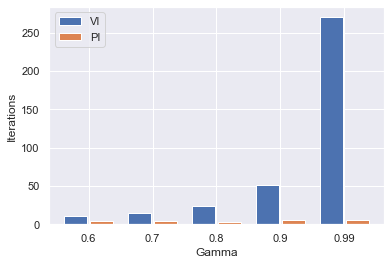

In [59]:
converge_iter = {"VI":[], "PI":[]}
range_gamma = [0.6,0.7,0.8,0.9,0.99]
for gamma in range_gamma:
    vi = mdp.ValueIteration(P, R, gamma,epsilon=0.001)
    vi_stat = vi.run()
    converge_iter['VI'].append(vi_stat[-1]['Iteration'])
    print("VI policy sucess:")
    success(env,vi)
    pi = mdp.PolicyIteration(P, R, gamma)
    pi_stat = pi.run()
    converge_iter['PI'].append(pi_stat[-1]['Iteration'])
    print("PI policy sucess:")
    success(env,pi)
    %reset_selective -f "^vi$"
    %reset_selective -f "^pi$"


fig, ax = plt.subplots()

ax.set_xticks(np.arange(len(converge_iter["VI"])))
ax.set_xticks(np.arange(len(range_gamma)))
ax.set_xticklabels(range_gamma)
bar_plot(ax, converge_iter, total_width=.8, single_width=.9)

plt.xlabel('Gamma')
plt.ylabel('Iterations')
# save_fig("LLE_heart_bic_vs_k")
plt.show()

In [83]:

def e_greedy(eps, Q, state, episode,noise=True,min_epsilon=0.0,epsilon_decay='const'):
    # if eps<= min_epsilon:
    #     eps= min_epsilon
    if np.random.rand() > max(eps,min_epsilon):
        if noise:
            action = np.argmax(Q[state,:]+np.random.randn(1, n_actions)/(episode/4))
        else:
            action = np.argmax(Q[state])
    else:
        action = env.action_space.sample()
        if epsilon_decay == 'const':
            eps -= 10**-5
        else:
            eps *= epsilon_decay

    return action, eps
def learn_Q(alpha, gamma, eps, numTrainingEpisodes, numTrainingSteps,min_epsilon=0.0,epsilon_decay='const',noise=True,early_stop=True):
    from time import time
    final_Score=0
    final_iter=0
    time_of_train=0
    start= time()
    epsilon_curve=[eps]
    Q = np.zeros([env.observation_space.n, env.action_space.n])
    global Q_star
    rewardTracker = []
    avg_tot_reward=[]
    episod_errors=[]
    pre_Q = np.zeros([env.observation_space.n, env.action_space.n])
    for episode in range(1,numTrainingEpisodes+1):  
        G = 0
        state = env.reset()
        error=[]
        for step in range(1,numTrainingSteps):
            action, eps = e_greedy(eps, Q, state, episode,noise,min_epsilon,epsilon_decay)
            epsilon_curve.append(eps)
            state2, reward, done, info = env.step(action)
            G += reward
            dQ=alpha * (reward + gamma * np.max(Q[state2]) - Q[state,action])
            #error.append(np.absolute(dQ))
            Q[state,action] += dQ #alpha * (reward + gamma * np.max(Q[state2]) - Q[state,action])
            state = state2
     
        delta_q = np.linalg.norm(Q-pre_Q)
        # print(delta_q) 
        pre_Q = Q.copy()  
        episod_errors.append(delta_q)#error)
        rewardTracker.append(G)
        avg_tot_reward.append(sum(rewardTracker)/episode)
        
        if episode % (numTrainingEpisodes*.10) == 0 and episode != 0:
            print('Alpha {}  Gamma {}  Epsilon {:04.3f}  Min Epsilon {} Decay {}  Episode {} of {}'.format(alpha, gamma, eps,min_epsilon,epsilon_decay, episode, numTrainingEpisodes))
            print("Average Total Return: {}".format(sum(rewardTracker)/episode))
        if early_stop:
            if (sum(rewardTracker[episode-100:episode])/100.0) > .78 or episode == numTrainingEpisodes: 
                final_Score=sum(rewardTracker[episode-100:episode])/100.0
                final_iter = episode-100
                print('-------------------------------------------------------')
                print('Fnished after {} episodes with average return of {}'.format(episode-100, final_Score))

                Q_star = Q
                break

    Q_star = Q
    time_of_train=time()-start
    return final_Score,final_iter,epsilon_curve,time_of_train,rewardTracker,avg_tot_reward,episod_errors,Q_star

In [84]:
# Gamma analysis
start =time()
gamma_range=[0.7,0.8,0.9,0.95,0.99]

parameters = []
epsilon_list=[]
learn_time=[]
iterations=[]
score_list=[]
episod_tot_reward=[]
episod_avg_tot_reward=[]
episod_errors_list = []

for g in gamma_range: 
        score,iteration,epsilon,time_to_learn,reward_stat,avg_reward,episod_errors,Q_s=learn_Q(alpha=0.8,gamma= g, eps=1, numTrainingEpisodes=5000,numTrainingSteps=300,min_epsilon=0,epsilon_decay=0.99)
        episod_tot_reward.append(reward_stat)
        episod_avg_tot_reward.append(avg_reward)
        episod_errors_list.append(episod_errors)
        learn_time.append(time_to_learn)
        iterations.append(iteration)
        score_list.append(score)
        %reset_selective -f "^eps$"

print(time()-start)

Alpha 0.8  Gamma 0.7  Epsilon 0.001  Min Epsilon 0 Decay 0.99  Episode 500 of 5000
Average Total Return: 0.028
Alpha 0.8  Gamma 0.7  Epsilon 0.000  Min Epsilon 0 Decay 0.99  Episode 1000 of 5000
Average Total Return: 0.028
Alpha 0.8  Gamma 0.7  Epsilon 0.000  Min Epsilon 0 Decay 0.99  Episode 1500 of 5000
Average Total Return: 0.03333333333333333
Alpha 0.8  Gamma 0.7  Epsilon 0.000  Min Epsilon 0 Decay 0.99  Episode 2000 of 5000
Average Total Return: 0.035
Alpha 0.8  Gamma 0.7  Epsilon 0.000  Min Epsilon 0 Decay 0.99  Episode 2500 of 5000
Average Total Return: 0.0344
Alpha 0.8  Gamma 0.7  Epsilon 0.000  Min Epsilon 0 Decay 0.99  Episode 3000 of 5000
Average Total Return: 0.03666666666666667
Alpha 0.8  Gamma 0.7  Epsilon 0.000  Min Epsilon 0 Decay 0.99  Episode 3500 of 5000
Average Total Return: 0.038857142857142854
Alpha 0.8  Gamma 0.7  Epsilon 0.000  Min Epsilon 0 Decay 0.99  Episode 4000 of 5000
Average Total Return: 0.0465
Alpha 0.8  Gamma 0.7  Epsilon 0.000  Min Epsilon 0 Decay 0.9

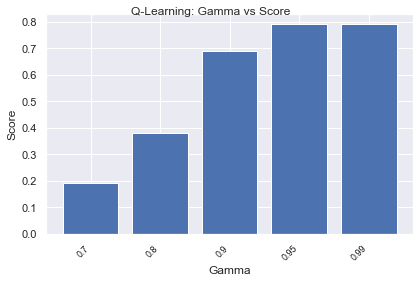

In [85]:
labels_g=[]
for p in gamma_range:
    labels_g.append(str(p))

fig, ax = plt.subplots()

ax.set_xticks(np.arange(len(labels_g)))
ax.bar(labels_g,score_list,width=0.8,align='center')
ax.set_xticklabels(labels_g,rotation=45,ha='right',fontsize=9,c='k')
fig.suptitle('Q-Learning: Gamma vs Score', fontsize=12)
plt.xlabel('Gamma', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.tight_layout()

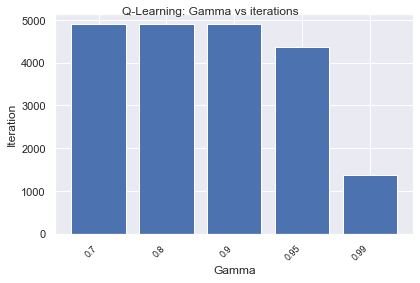

In [86]:
fig, ax = plt.subplots()

ax.set_xticks(np.arange(len(labels_g)))
ax.bar(labels_g,iterations,width=0.8,align='center')
ax.set_xticklabels(labels_g,rotation=45,ha='right',fontsize=9,c='k')
fig.suptitle('Q-Learning: Gamma vs iterations', fontsize=12)
plt.xlabel('Gamma', fontsize=12)
plt.ylabel('Iteration', fontsize=12)
plt.tight_layout()

In [10]:

before=time()

parameters = []
epsilon_list=[]
learn_time=[]
iterations=[]
score_list=[]
episod_tot_reward=[]
episod_avg_tot_reward=[]
episod_errors_list = []

min_epsilon_range =[0.1,0.05,0]
alpha_range=[0.2,0.5,0.8]
epsilon_decay_range=[0.99,0.999999,'const']
eps_range=[0.1,0.5,1]
for alph, min_eps,eps_decay,ep in product(alpha_range, min_epsilon_range,epsilon_decay_range,eps_range): 
    print((alph, min_eps,eps_decay,ep))
    score,iteration,epsilon,time_to_learn,reward_stat,avg_reward,episod_errors,Q_s=learn_Q(alpha=alph,gamma= 0.95, eps=ep, numTrainingEpisodes=5000,numTrainingSteps=300,min_epsilon=min_eps,epsilon_decay=eps_decay)
    parameters.append((alph, min_eps,eps_decay,ep))
    episod_tot_reward.append(reward_stat)
    episod_avg_tot_reward.append(avg_reward)
    episod_errors_list.append(episod_errors)
    epsilon_list.append(epsilon)
    learn_time.append(time_to_learn)
    iterations.append(iteration)
    score_list.append(score)
    %reset_selective -f "^eps$"

print(time()-before)

sode 2500 of 5000
Average Total Return: 0.1152
Alpha 0.8  Gamma 0.95  Epsilon -0.568  Min Epsilon 0.1 Decay const  Episode 3000 of 5000
Average Total Return: 0.12666666666666668
Alpha 0.8  Gamma 0.95  Epsilon -0.719  Min Epsilon 0.1 Decay const  Episode 3500 of 5000
Average Total Return: 0.12971428571428573
Alpha 0.8  Gamma 0.95  Epsilon -0.868  Min Epsilon 0.1 Decay const  Episode 4000 of 5000
Average Total Return: 0.13625
Alpha 0.8  Gamma 0.95  Epsilon -1.015  Min Epsilon 0.1 Decay const  Episode 4500 of 5000
Average Total Return: 0.13822222222222222
Alpha 0.8  Gamma 0.95  Epsilon -1.164  Min Epsilon 0.1 Decay const  Episode 5000 of 5000
Average Total Return: 0.1408
-------------------------------------------------------
Fnished after 4900 episodes with average return of 0.18
(0.8, 0.05, 0.99, 0.1)
Alpha 0.8  Gamma 0.95  Epsilon 0.000  Min Epsilon 0.05 Decay 0.99  Episode 500 of 5000
Average Total Return: 0.188
Alpha 0.8  Gamma 0.95  Epsilon 0.000  Min Epsilon 0.05 Decay 0.99  Episod

In [ ]:
# Epsilon 
plt.plot(epsilon_list[-1],labels=labels[-1])
plt.plot(epsilon_list[-4],,labels=labels[-4])
plt.plot(epsilon_list[-7],labels=labels[-7])
plt.xlabel("Iteration")
plt.ylabel("Epsilon")
plt.legend()
plt.tight_layout()

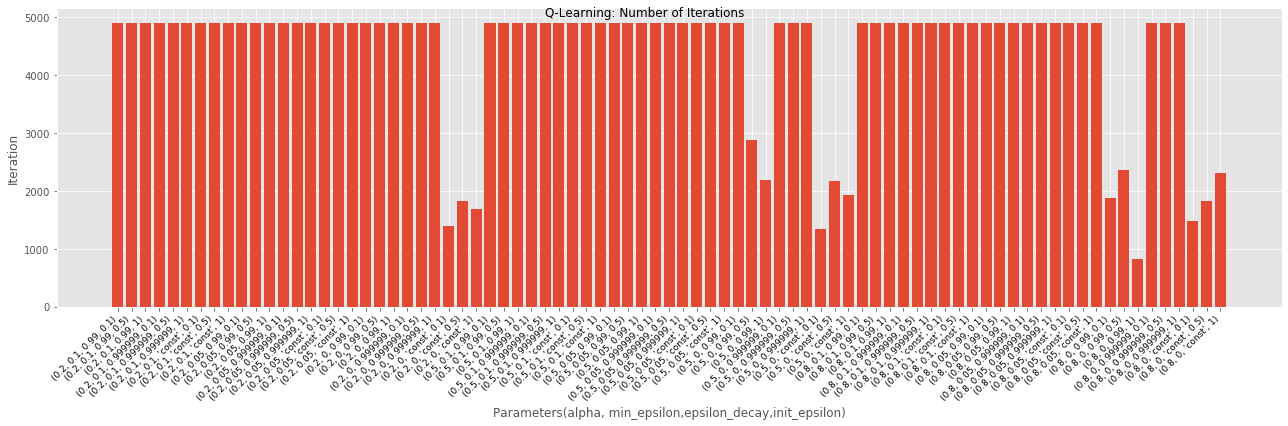

In [39]:
labels=[]
for p in parameters:
    labels.append(str(p))

fig, ax = plt.subplots(figsize=(18, 6))

ax.set_xticks(np.arange(len(labels)))
ax.bar(labels,iterations,width=0.8,align='center')
ax.set_xticklabels(labels,rotation=45,ha='right',fontsize=9,c='k')
fig.suptitle('Q-Learning: Number of Iterations', fontsize=12)
plt.xlabel('Parameters(alpha, min_epsilon,epsilon_decay,init_epsilon)', fontsize=12)
plt.ylabel('Iteration', fontsize=12)
plt.tight_layout()

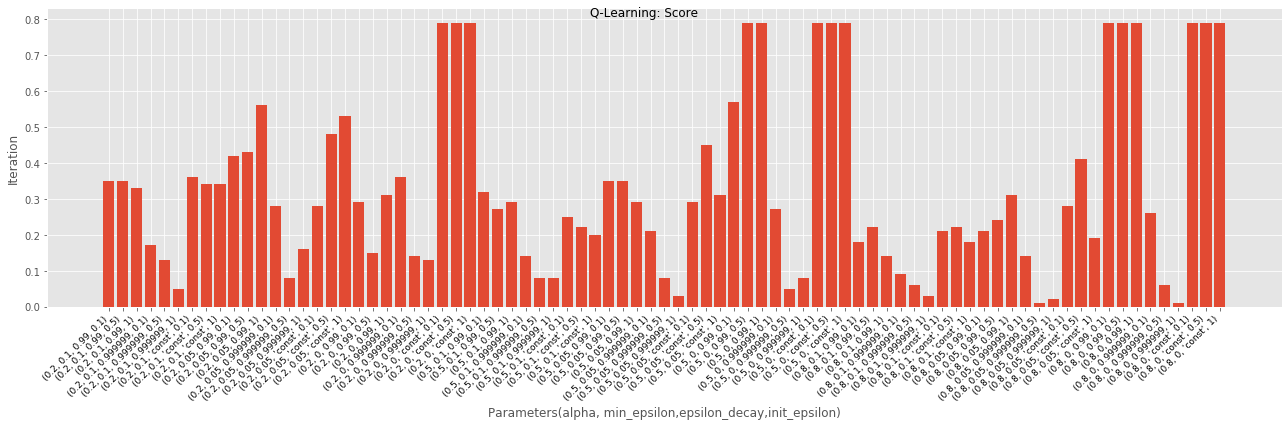

In [31]:
labels=[]
for p in parameters:
    labels.append(str(p))
fig, ax = plt.subplots(figsize=(18, 6))
    # plt.figure(figsize=(8, 6))

ax.set_xticks(np.arange(len(labels)))
ax.bar(labels,score_list,width=0.8,align='center')
ax.set_xticklabels(labels,rotation=45,ha='right',fontsize=9,c='k')
fig.suptitle('Q-Learning: Score', fontsize=12)
plt.xlabel('Parameters(alpha, min_epsilon,epsilon_decay,init_epsilon)', fontsize=12)
plt.ylabel('Iteration', fontsize=12)
plt.tight_layout()

Text(0, 0.5, 'Delta(Q value)')

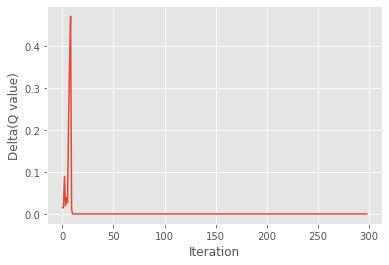

In [40]:
#Error 
plt.plot(episod_errors_list[-7][-1])
episod_errors_list[-7][-1][-1]
plt.xlabel("Iteration")
plt.ylabel("Delta(Q value)")

In [91]:
score,iteration,epsilon,time_to_learn,reward_stat,avg_reward,episod_errors,Q_s=learn_Q(alpha=0.8,gamma= 0.95, eps=1, numTrainingEpisodes=10000,numTrainingSteps=1000,min_epsilon=0,epsilon_decay=0.99,early_stop=False)

Alpha 0.8  Gamma 0.95  Epsilon 0.000  Min Epsilon 0 Decay 0.99  Episode 1000 of 10000
Average Total Return: 0.438
Alpha 0.8  Gamma 0.95  Epsilon 0.000  Min Epsilon 0 Decay 0.99  Episode 2000 of 10000
Average Total Return: 0.5605
Alpha 0.8  Gamma 0.95  Epsilon 0.000  Min Epsilon 0 Decay 0.99  Episode 3000 of 10000
Average Total Return: 0.5983333333333334
Alpha 0.8  Gamma 0.95  Epsilon 0.000  Min Epsilon 0 Decay 0.99  Episode 4000 of 10000
Average Total Return: 0.6015
Alpha 0.8  Gamma 0.95  Epsilon 0.000  Min Epsilon 0 Decay 0.99  Episode 5000 of 10000
Average Total Return: 0.6048
Alpha 0.8  Gamma 0.95  Epsilon 0.000  Min Epsilon 0 Decay 0.99  Episode 6000 of 10000
Average Total Return: 0.611
Alpha 0.8  Gamma 0.95  Epsilon 0.000  Min Epsilon 0 Decay 0.99  Episode 7000 of 10000
Average Total Return: 0.6184285714285714
Alpha 0.8  Gamma 0.95  Epsilon 0.000  Min Epsilon 0 Decay 0.99  Episode 8000 of 10000
Average Total Return: 0.626625
Alpha 0.8  Gamma 0.95  Epsilon 0.000  Min Epsilon 0 Deca

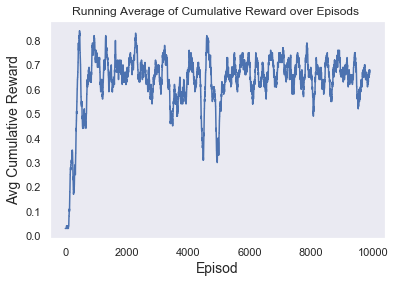

In [101]:
def running_average(x, window_size, mode='valid'):
        return np.convolve(x, np.ones(window_size)/window_size, mode=mode)

err= running_average(reward_stat, 100, mode='valid')
plt.plot(err)
plt.xlabel("Episod", fontsize=14)
plt.ylabel("Avg Cumulative Reward", fontsize=14) 
plt.title("Running Average of Cumulative Reward over Episods ")
plt.grid() 

In [132]:
score,iteration,epsilon,time_to_learn,reward_stat,avg_reward,episod_errors,Q_s=learn_Q(alpha=0.8,gamma= 0.95, eps=1, numTrainingEpisodes=10000,numTrainingSteps=1000,min_epsilon=0,epsilon_decay=0.99,early_stop=False)

Alpha 0.8  Gamma 0.95  Epsilon 0.000  Min Epsilon 0 Decay 0.99  Episode 1000 of 10000
Average Total Return: 0.464
Alpha 0.8  Gamma 0.95  Epsilon 0.000  Min Epsilon 0 Decay 0.99  Episode 2000 of 10000
Average Total Return: 0.628
Alpha 0.8  Gamma 0.95  Epsilon 0.000  Min Epsilon 0 Decay 0.99  Episode 3000 of 10000
Average Total Return: 0.6836666666666666
Alpha 0.8  Gamma 0.95  Epsilon 0.000  Min Epsilon 0 Decay 0.99  Episode 4000 of 10000
Average Total Return: 0.70525
Alpha 0.8  Gamma 0.95  Epsilon 0.000  Min Epsilon 0 Decay 0.99  Episode 5000 of 10000
Average Total Return: 0.7166
Alpha 0.8  Gamma 0.95  Epsilon 0.000  Min Epsilon 0 Decay 0.99  Episode 6000 of 10000
Average Total Return: 0.7266666666666667
Alpha 0.8  Gamma 0.95  Epsilon 0.000  Min Epsilon 0 Decay 0.99  Episode 7000 of 10000
Average Total Return: 0.7327142857142858
Alpha 0.8  Gamma 0.95  Epsilon 0.000  Min Epsilon 0 Decay 0.99  Episode 8000 of 10000
Average Total Return: 0.744125
Alpha 0.8  Gamma 0.95  Epsilon 0.000  Min E

In [104]:
ql_policy=Q_s.argmax(axis=1)
Q_v= Q_s.max(axis=1)

In [ ]:
# # actions = {
#     'Left': 0,
#     'Down': 1,
#     'Right': 2, 
#     'Up': 3
# }
pol=ql_policy.reshape(4,4)
labels = np.empty(pol.shape,dtype=object)
print(labels.shape)

for i in range(pol.shape[0]):
    for j in range(pol.shape[1]):
        if pol[i,j]==0:
            labels[i,j]='Left'
        elif pol[i,j]==1:
            labels[i,j]='Down'
        elif pol[i,j]==2:
            labels[i,j]='Right'
        else:
            labels[i,j]='Up'
labels

(16,)


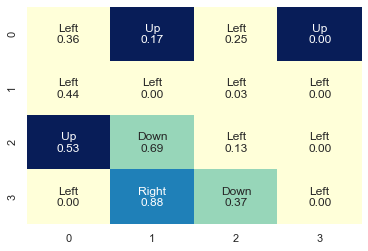

In [108]:
sns.set_theme()

tag = (np.asarray(["{0}\n{1:.2f}".format(label,vs) for label, vs in zip(labels.flatten(), Q_v.flatten())])).reshape(4,4)
print(ql_policy.shape)
fig, ax = plt.subplots()
ax = sns.heatmap(pol,annot=tag, cmap="YlGnBu", cbar=False,fmt = '')

In [4]:

env_large = gym.make("FrozenLake8x8-v0",is_slippery=True)
env_large=env_large.unwrapped

###################################
np.random.seed(0)
env_large.seed(0)
###################################
env_large.reset()                    
n_state = env_large.observation_space.n
n_actions = env_large.action_space.n
print(n_state)

64


Converged after 1 value iterations
[3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 2, 2, 1, 3, 3, 0, 0, 2, 3, 2, 1, 3, 3, 3, 1, 0, 0, 2, 2, 0, 3, 0, 0, 2, 1, 3, 2, 0, 0, 0, 1, 3, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 2, 0, 1, 0, 0, 1, 2, 1, 0]
Won 88 of 100 games!
[[0.41456626 0.42713971 0.44609053 0.4682701  0.49240003 0.51653127
  0.53522487 0.54093947]
 [0.4116141  0.42114208 0.43743729 0.45833752 0.48319639 0.51349576
  0.54573457 0.5573368 ]
 [0.39668108 0.39377559 0.3754391  0.         0.42164238 0.49378533
  0.56118254 0.58583104]
 [0.36920441 0.35292225 0.30648377 0.20037863 0.30072556 0.
  0.56899026 0.62823463]
 [0.33254677 0.29130311 0.19726967 0.         0.2892696  0.36193303
  0.53479806 0.68967787]
 [0.30597996 0.         0.         0.08626557 0.21391767 0.27270085
  0.         0.7720221 ]
 [0.28870222 0.         0.05765777 0.0474947  0.         0.2505158
  0.         0.87776196]
 [0.28019195 0.20066518 0.12723136 0.         0.23958878 0.48643814
  0.73710132 0.        ]]


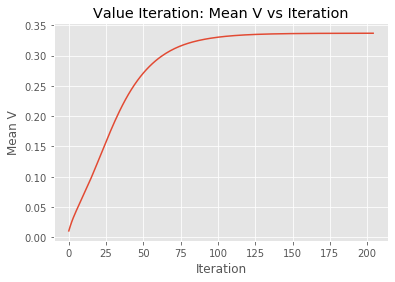

In [10]:
### Value ITERATION######

def eval_state_action(env,V, s, a, gamma=0.99):
    return np.sum([p * (rew + gamma*V[next_s]) for p, next_s, rew, _ in env.P[s][a]])

def value_iteration(env,nS,nA,eps=0.0000001,g=0.99):
    '''
    Value iteration algorithm
    '''
    # # spaces dimension
    nA = env.action_space.n
    nS = env.observation_space.n
    V = np.zeros(nS)
    it = 0
    avg_V=[]
    while True:
        delta = 0
        # update the value of each state using as "policy" the max operator
        for s in range(nS):
            old_v = V[s]
            V[s] = np.max([eval_state_action(env,V, s, a,g) for a in range(nA)])
            delta = max(delta, np.abs(old_v - V[s]))
            # deltas.append(delta)
        if delta < eps:
            break
        # else:
        #     print('Iter:', it, ' delta:', np.round(delta, 5))

        avg_V.append(np.mean(V))
        it += 1

    return V,avg_V,it

def run_episodes(env, V, num_games=100):
    '''
    Run some test games
    '''
    tot_rew = 0
    state = env.reset()

    for _ in range(num_games):
        done = False
        while not done:
            action = np.argmax([eval_state_action(env,V, state, a) for a in range(nA)])
            next_state, reward, done, _ = env.step(action)

            state = next_state
            tot_rew += reward 
            if done:
                state = env.reset()
    print('Won %i of %i games!'%(tot_rew, num_games))
    return tot_rew

def policy_maker(env,V,n_states,n_actions,g):
    policy=[]
    for s in range(n_states):
        policy.append(np.argmax([eval_state_action(env,V, s, a,g) for a in range(n_actions)]))
    return policy

def value_iteration_fun(env,nS,nA,eps=0.00001,gamma=0.99):
    # Value iteration
    start_time=time()
    V,vi_error,vi_conv_iter = value_iteration(env,nS,nA,eps,gamma)

    vi_conv_time = time()-start_time
    return V,vi_error,vi_conv_iter,vi_conv_time

nS = env_large.observation_space.n
nA = env_large.action_space.n    
V_2,vi2_mean,vi2_conv_iter,vi2_conv_time = value_iteration_fun(env_large,nS,nA,eps=0.00001,gamma=0.99)
print('Converged after %i value iterations'%(vi2_conv_time))

vi_V_2 = V_2.reshape((8,8))

plt.plot(vi2_mean)
plt.title("Value Iteration: Mean V vs Iteration")
plt.ylabel("Mean V")
plt.xlabel("Iteration")

vi_policy_2 = policy_maker(env_large,V_2,n_state,n_actions,g=0.99)#.reshape((4,4)
print(vi_policy_2)

vi_tot_rew_2 = run_episodes(env_large, V_2, 100)

print(vi_V_2.reshape((8,8)))

Converged after 10 policy iterations
Won 72 of 100 games!
[[0.04825013 0.0558686  0.06811762 0.08391798 0.1024678  0.11983684
  0.13396307 0.13978559]
 [0.04666171 0.05244095 0.0630727  0.07861838 0.10127789 0.12463224
  0.14929263 0.16185701]
 [0.0422161  0.04443621 0.04566782 0.         0.09272489 0.12444603
  0.17563033 0.19997776]
 [0.03688347 0.03737456 0.03670526 0.03286898 0.06709152 0.
  0.20535172 0.25590062]
 [0.02997273 0.02779454 0.02042494 0.         0.08627408 0.13289285
  0.21694816 0.34685489]
 [0.02163677 0.         0.         0.02610792 0.07246011 0.1164394
  0.         0.49257573]
 [0.01671727 0.         0.00542666 0.00998595 0.         0.1623504
  0.         0.71607168]
 [0.01443749 0.01000434 0.00715093 0.         0.18362624 0.39624609
  0.67143111 0.        ]]
[[3. 2. 2. 2. 2. 2. 2. 2.]
 [3. 3. 3. 3. 2. 2. 2. 1.]
 [3. 3. 0. 0. 2. 3. 2. 1.]
 [3. 3. 3. 1. 0. 0. 2. 1.]
 [3. 3. 0. 0. 2. 1. 3. 2.]
 [0. 0. 0. 1. 3. 0. 0. 2.]
 [0. 0. 1. 0. 0. 0. 0. 2.]
 [0. 1. 0. 0. 1. 1

Text(0.5, 0, 'Iteration')

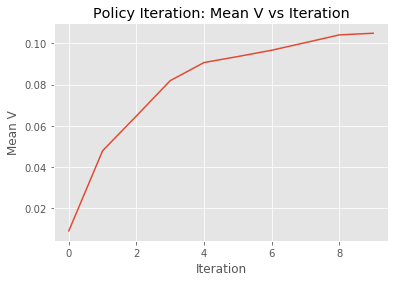

In [11]:
### POLICY ITERATION######
def eval_state_action(env,V, s, a, gamma=0.99):
    return np.sum([p * (rew + gamma*V[next_s]) for p, next_s, rew, _ in env.P[s][a]])

def policy_evaluation(env,V, policy,gamma=0.99, eps=0.0000001):
    '''
    Policy evaluation. Update the value function until it reach a steady state
    '''
    # deltas=[]
    while True:
        delta = 0
        for s in range(nS):
            old_v = V[s]
            # update V[s] using the Bellman equation
            V[s] = eval_state_action(env,V, s, policy[s],gamma)
            delta = max(delta, np.abs(old_v - V[s]))
            # deltas.append(delta)
        if delta < eps:
            break
    return V

def policy_improvement(env,V, policy,nS,nA):
    '''
    Policy improvement. Update the policy based on the value function
    '''
    nS = env.observation_space.n
    nA = env.action_space.n
    policy_stable = True
    for s in range(nS):
        old_a = policy[s]
        # update the policy with the action that bring to the highest state value
        policy[s] = np.argmax([eval_state_action(env,V, s, a) for a in range(nA)])
        if old_a != policy[s]: 
            policy_stable = False

    return policy_stable, policy,np.mean(V)


def run_episodes(env, policy, num_games=100):
    '''
    Run some games to test a policy
    '''
    tot_rew = 0
    state = env.reset()

    for _ in range(num_games):
        done = False
        while not done:
            # select the action accordingly to the policy
            next_state, reward, done, _ = env.step(policy[state])
                
            state = next_state
            tot_rew += reward 
            if done:
                state = env.reset()

    print('Won %i of %i games!'%(tot_rew, num_games))
    return tot_rew
#######################################################
def policy_iteration(env,gamma,nS,nA):
    pi_V = np.zeros(nS)
    pi_policy = np.zeros(nS)
    
    policy_stable = False
    it = 0
    PI_avg_V=[]
    pi_conv_time=0
    start_time=time()
    while not policy_stable:
        pi_V = policy_evaluation(env,pi_V, pi_policy,gamma)
        policy_stable,pi_policy,avg_v = policy_improvement(env,pi_V, pi_policy,nS,nA)
        PI_avg_V.append(avg_v)
        it += 1
    pi_conv_time = time()-start_time
    pi_conv_iter = it
    return pi_V,pi_policy,pi_conv_iter,pi_conv_time,PI_avg_V

nS = env_large.observation_space.n
nA = env_large.action_space.n
pi_V_2,pi_policy_2,pi_conv_iter_2,pi_conv_time_2,PI_mean_V_2 = policy_iteration(env_large,0.95,nS,nA)
print('Converged after %i policy iterations'%(pi_conv_iter_2))
pi_tot_rew_2=run_episodes(env_large, pi_policy_2)
pi_V_2 = pi_V_2.reshape((8,8))
print(pi_V_2)
print(pi_policy_2.reshape((8,8)))
plt.plot(PI_mean_V_2)
plt.title("Policy Iteration: Mean V vs Iteration")

plt.ylabel("Mean V")
plt.xlabel("Iteration")
# pi_policy=pi_policy.reshape((4,4))

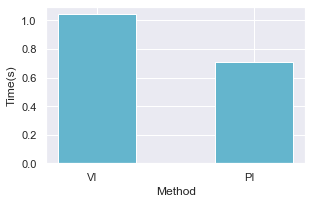

In [22]:

fig, ax = plt.subplots(figsize=(4.5,3))
ax.set_xticks(np.arange(2))
ax.bar(['VI','PI'],[vi2_conv_time,pi_conv_time_2],width=0.5,align='center',color='c')
ax.set_xticklabels(['VI','PI'],rotation=0,ha='right')
plt.ylabel("Time(s)")
plt.xlabel("Method")

plt.tight_layout()

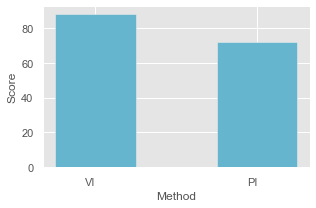

In [59]:
fig, ax = plt.subplots(figsize=(4.5,3))
ax.set_xticks(np.arange(2))
ax.bar(['VI','PI'],[vi_tot_rew_2,pi_tot_rew_2],width=0.5,align='center',color='c')
ax.set_xticklabels(['VI','PI'],rotation=0,ha='right')
plt.ylabel("Score")
plt.xlabel("Method")

plt.tight_layout()

In [12]:
pi_policy_2.size

64

In [13]:
np.array(vi_policy_2).size

64

In [14]:
pi_policy_2==np.array(vi_policy_2)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True])

In [16]:
# # actions = {
#     'Left': 0,
#     'Down': 1,
#     'Right': 2, 
#     'Up': 3
# }
pol=np.array(vi_policy_2).reshape(8,8)
# print(pol.shape)
# pol = pi_policy
labels = np.empty(pol.shape,dtype=object)
print(labels.shape)

for i in range(pol.shape[0]):
    for j in range(pol.shape[1]):
        if pol[i,j]==0:
            labels[i,j]='Left'
        elif pol[i,j]==1:
            labels[i,j]='Down'
        elif pol[i,j]==2:
            labels[i,j]='Right'
        else:
            labels[i,j]='Up'
        # if i==pol.shape[0]-1 and j==pol.shape[1]-1:
        #     labels[i,j]='G'
labels

(8, 8)


array([['Up', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right',
        'Right'],
       ['Up', 'Up', 'Up', 'Up', 'Up', 'Right', 'Right', 'Down'],
       ['Up', 'Up', 'Left', 'Left', 'Right', 'Up', 'Right', 'Down'],
       ['Up', 'Up', 'Up', 'Down', 'Left', 'Left', 'Right', 'Right'],
       ['Left', 'Up', 'Left', 'Left', 'Right', 'Down', 'Up', 'Right'],
       ['Left', 'Left', 'Left', 'Down', 'Up', 'Left', 'Left', 'Right'],
       ['Left', 'Left', 'Down', 'Left', 'Left', 'Left', 'Left', 'Right'],
       ['Left', 'Down', 'Left', 'Left', 'Down', 'Right', 'Down', 'Left']],
      dtype=object)

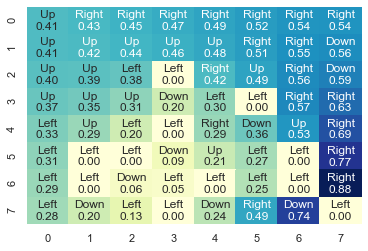

In [18]:
sns.set_theme()
# Reference: https://likegeeks.com/seaborn-heatmap-tutorial/
tag = (np.asarray(["{0}\n{1:.2f}".format(label,vs) for label, vs in zip(labels.flatten(), vi_V_2.flatten())])).reshape(8,8)
fig, ax = plt.subplots()

In [19]:
# # actions = {
#     'Left': 0,
#     'Down': 1,
#     'Right': 2, 
#     'Up': 3
# }
pol=np.array(pi_policy_2).reshape(8,8)

labels = np.empty(pol.shape,dtype=object)
print(labels.shape)

for i in range(pol.shape[0]):
    for j in range(pol.shape[1]):
        if pol[i,j]==0:
            labels[i,j]='Left'
        elif pol[i,j]==1:
            labels[i,j]='Down'
        elif pol[i,j]==2:
            labels[i,j]='Right'
        else:
            labels[i,j]='Up'
        # if i==pol.shape[0]-1 and j==pol.shape[1]-1:
        #     labels[i,j]='G'
labels

(8, 8)


array([['Up', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right',
        'Right'],
       ['Up', 'Up', 'Up', 'Up', 'Right', 'Right', 'Right', 'Down'],
       ['Up', 'Up', 'Left', 'Left', 'Right', 'Up', 'Right', 'Down'],
       ['Up', 'Up', 'Up', 'Down', 'Left', 'Left', 'Right', 'Down'],
       ['Up', 'Up', 'Left', 'Left', 'Right', 'Down', 'Up', 'Right'],
       ['Left', 'Left', 'Left', 'Down', 'Up', 'Left', 'Left', 'Right'],
       ['Left', 'Left', 'Down', 'Left', 'Left', 'Left', 'Left', 'Right'],
       ['Left', 'Down', 'Left', 'Left', 'Down', 'Down', 'Down', 'Left']],
      dtype=object)

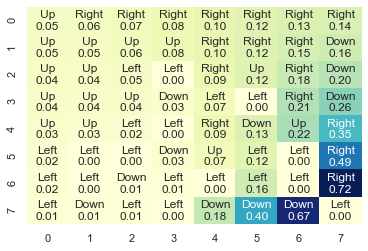

In [21]:
sns.set_theme()
tag = (np.asarray(["{0}\n{1:.2f}".format(label,vs) for label, vs in zip(labels.flatten(), pi_V_2.flatten())])).reshape(8,8)
fig, ax = plt.subplots()
ax = sns.heatmap(pi_V_2,annot=tag, cmap="YlGnBu", cbar=False,fmt = '')

In [60]:
def e_greedy(eps, Q, state, episode,noise=True,min_epsilon=0.0,epsilon_decay='const'):
    # if eps<= min_epsilon:
    #     eps= min_epsilon
    if np.random.rand() > max(eps,min_epsilon):
        if noise:
            action = np.argmax(Q[state,:]+np.random.randn(1, n_actions)/(episode/4))
        else:
            action = np.argmax(Q[state])
    else:
        action = env.action_space.sample()
        if epsilon_decay == 'const':
            eps -= 10**-5
        else:
            eps *= epsilon_decay

    return action, eps
def learn_Q_large(env,alpha, gamma, eps, numTrainingEpisodes, numTrainingSteps,min_epsilon=0.0,epsilon_decay='const',noise=True,early_stop=True):
    from time import time
    final_Score=0
    final_iter=0
    time_of_train=0
    start= time()
    epsilon_curve=[eps]
    Q = np.zeros([env.observation_space.n, env.action_space.n])
    global Q_star
    rewardTracker = []
    avg_tot_reward=[]
    episod_errors=[]
    pre_Q = np.zeros([env.observation_space.n, env.action_space.n])
    for episode in range(1,numTrainingEpisodes+1):  
        G = 0
        state = env.reset()
        error=[]
        for step in range(1,numTrainingSteps):
            action, eps = e_greedy(eps, Q, state, episode,noise,min_epsilon,epsilon_decay)
            epsilon_curve.append(eps)
            state2, reward, done, info = env.step(action)
            G += reward
            dQ=alpha * (reward + gamma * np.max(Q[state2]) - Q[state,action])
            #error.append(np.absolute(dQ))
            Q[state,action] += dQ #alpha * (reward + gamma * np.max(Q[state2]) - Q[state,action])
            state = state2
     
        delta_q = np.linalg.norm(Q-pre_Q)
        # print(delta_q) 
        pre_Q = Q.copy()  
        episod_errors.append(delta_q)#error)
        rewardTracker.append(G)
        avg_tot_reward.append(sum(rewardTracker)/episode)
        
        if episode % (numTrainingEpisodes*.10) == 0 and episode != 0:
            print('Alpha {}  Gamma {}  Epsilon {:04.3f}  Min Epsilon {} Decay {}  Episode {} of {}'.format(alpha, gamma, eps,min_epsilon,epsilon_decay, episode, numTrainingEpisodes))
            print("Average Total Return: {}".format(sum(rewardTracker)/episode))
        if early_stop:
            if (sum(rewardTracker[episode-100:episode])/100.0) > .78 or episode == numTrainingEpisodes: 
                final_Score=sum(rewardTracker[episode-100:episode])/100.0
                final_iter = episode-100
                print('-------------------------------------------------------')
                print('Fnished after {} episodes with average return of {}'.format(episode-100, final_Score))

                Q_star = Q
                break

    Q_star = Q
    time_of_train=time()-start
    return final_Score,final_iter,epsilon_curve,time_of_train,rewardTracker,avg_tot_reward,episod_errors,Q_star

In [61]:
score_large,iteration_large,epsilon_large,time_to_learn_large,reward_stat_large,avg_reward_large,episod_errors_large,Q_s_large=learn_Q_large(env_large,alpha=0.8,gamma= 0.95, eps=1, numTrainingEpisodes=20000,numTrainingSteps=1000,min_epsilon=0,epsilon_decay=0.99,early_stop=False)


Alpha 0.8  Gamma 0.95  Epsilon 0.000  Min Epsilon 0 Decay 0.99  Episode 1000 of 10000
Average Total Return: 0.0
Alpha 0.8  Gamma 0.95  Epsilon 0.000  Min Epsilon 0 Decay 0.99  Episode 2000 of 10000
Average Total Return: 0.0075
Alpha 0.8  Gamma 0.95  Epsilon 0.000  Min Epsilon 0 Decay 0.99  Episode 3000 of 10000
Average Total Return: 0.04566666666666667
Alpha 0.8  Gamma 0.95  Epsilon 0.000  Min Epsilon 0 Decay 0.99  Episode 4000 of 10000
Average Total Return: 0.0865
Alpha 0.8  Gamma 0.95  Epsilon 0.000  Min Epsilon 0 Decay 0.99  Episode 5000 of 10000
Average Total Return: 0.1418
Alpha 0.8  Gamma 0.95  Epsilon 0.000  Min Epsilon 0 Decay 0.99  Episode 6000 of 10000
Average Total Return: 0.20133333333333334
Alpha 0.8  Gamma 0.95  Epsilon 0.000  Min Epsilon 0 Decay 0.99  Episode 7000 of 10000
Average Total Return: 0.2422857142857143
Alpha 0.8  Gamma 0.95  Epsilon 0.000  Min Epsilon 0 Decay 0.99  Episode 8000 of 10000
Average Total Return: 0.283625
Alpha 0.8  Gamma 0.95  Epsilon 0.000  Min E

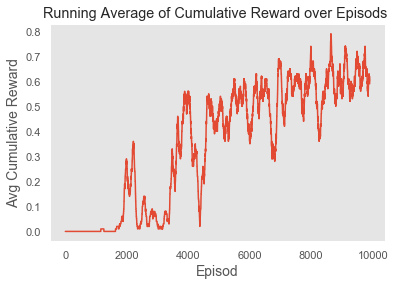

In [62]:
def running_average(x, window_size, mode='valid'):
        return np.convolve(x, np.ones(window_size)/window_size, mode=mode)


err= running_average(reward_stat_large, 100, mode='valid')
plt.plot(err)
plt.xlabel("Episod", fontsize=14)
plt.ylabel("Avg Cumulative Reward", fontsize=14) 
plt.title("Running Average of Cumulative Reward over Episods ")
plt.grid() 